In [19]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [2]:
print(torch.backends.mps.is_built())

True


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Set memory limit
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set the desired memory limit (in MB)
    except RuntimeError as e:
        print(e)


In [5]:
torch.set_default_device(0)

## Data loading and exploration

In [6]:
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [7]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [8]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [10]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

In [11]:
data['Labels'].value_counts()

Labels
Lung Adenocarcinoma             5000
Colon Benign Tissue             5000
Colon Adenocarcinoma            5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Name: count, dtype: int64

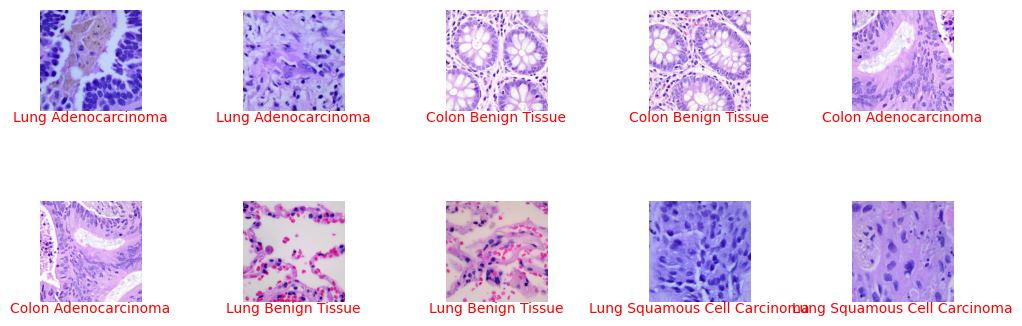

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = plt.imread(filepath)

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    annotation_x = 768 // 2
    annotation_y = 768 + 2
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Preprocessing

In [13]:
encoder = LabelEncoder()
encoded = encoder.fit_transform(data['Labels'])
data["Labels"] = encoder.fit_transform(data['Labels'])
reverse_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
# Print the mapping
for number, label in reverse_mapping.items():
    print("Number: {}, Label: {}".format(number, label))

Number: 0, Label: Colon Adenocarcinoma
Number: 1, Label: Colon Benign Tissue
Number: 2, Label: Lung Adenocarcinoma
Number: 3, Label: Lung Benign Tissue
Number: 4, Label: Lung Squamous Cell Carcinoma


In [14]:
traindf,validationdf = train_test_split(data,random_state=25,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,random_state=25,train_size=0.5 ,stratify = validationdf['Labels'])

In [15]:
traindf["Labels"].value_counts()

Labels
1    4000
4    4000
0    4000
3    4000
2    4000
Name: count, dtype: int64

In [15]:
validationdf['Labels'].value_counts()

Labels
2    500
4    500
1    500
0    500
3    500
Name: count, dtype: int64

In [17]:
testdf['Labels'].value_counts()

Labels
3    500
0    500
4    500
1    500
2    500
Name: count, dtype: int64

In [16]:
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    resized_image = resize(image)
    normalized_image = normalize(np.array(resized_image))
    return normalized_image.flatten()

def resize(image):
    return image.resize((256,256))

def normalize(image):
    return image/255.0
    
# Preprocess the data

In [ ]:
# Initialize empty lists to store pixel values
pixel_values = []

# Iterate over the dataset and collect pixel values
for image in data['Filepaths']:
    im = Image.open(image)
    pixel_values.append(np.array(im).flatten())

# Compute the mean and std of the pixel values
pixel_values = np.concatenate(pixel_values, axis=0)
mean = np.mean(pixel_values, axis=0)
std = np.std(pixel_values, axis=0)

print("Mean:", mean)
print("Standard Deviation:", std)

In [19]:
train_df = pd.DataFrame()
train_df['Images'] = [preprocess_image(image_path) for image_path in traindf["Filepaths"]]
train_df['Labels'] = traindf['Labels'].reset_index(drop=True)

In [20]:
train_df.head()

,Images,Labels
0,"[0.3176470588235294, 0.11372549019607843, 0.63...",1
1,"[0.29411764705882354, 0.20392156862745098, 0.7...",4
2,"[0.9215686274509803, 0.8235294117647058, 0.921...",1
3,"[0.9568627450980393, 0.8, 0.9215686274509803, ...",0
4,"[0.807843137254902, 0.8117647058823529, 0.9921...",4


In [21]:
test_df = pd.DataFrame()
test_df['Images'] = [preprocess_image(image_path) for image_path in testdf["Filepaths"]]
test_df['Labels'] = testdf['Labels'].reset_index(drop=True)

In [21]:
test_df.head()

,Images,Labels
0,"[0.8745098039215686, 0.7803921568627451, 0.780...",3
1,"[0.8862745098039215, 0.7686274509803922, 0.933...",0
2,"[0.6470588235294118, 0.30980392156862746, 0.76...",4
3,"[0.7647058823529411, 0.788235294117647, 0.8784...",4
4,"[0.8509803921568627, 0.788235294117647, 0.8235...",3


In [ ]:
validation_df = pd.DataFrame()
validation_df['Images'] = [preprocess_image(image_path) for image_path in validationdf["Filepaths"]]
validation_df['Labels'] = validationdf['Labels'].reset_index(drop=True)

In [ ]:
validation_df.head()

In [ ]:
np.prod(train_df['Images'][0].shape)# no of features

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [ ]:
# Prepare the feature matrix
X_train = np.stack(train_df['Images'].values)

# Prepare the target vector
y_train = train_df['Labels'].values


In [ ]:
import numpy as np
import gc
# Define the batch size
batch_size = 100

# Get the total number of images
total_images = len(train_df)

# Initialize an empty list to store the image vectors
image_vectors = []

# Process the images in batches
for i in range(0, total_images, batch_size):
    # Get the current batch of images
    batch_images = train_df['Images'].values[i:i+batch_size]
    
    # Convert the batch of images to a numpy array
    batch_images = np.stack(batch_images)
    
    # Process the batch of images and append the image vectors
    for image in batch_images:
        # Flatten the image array to a 1D vector
        image_vector = image.flatten()
        
        # Append the image vector to the list
        image_vectors.append(image_vector)

    # Clear the memory
    del batch_images
    gc.collect()

# Convert the list of image vectors to a numpy array
image_vectors = np.array(image_vectors)

# Prepare the feature matrix
X_train = image_vectors

# Prepare the target vector
y_train = train_df['Labels'].values


In [ ]:
# Prepare the feature matrix
clf.fit(X_train,y_train)

In [21]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
BATCH_SIZE = 50
train_set = datasets.ImageFolder("lung_colon_image_set", transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_set = datasets.ImageFolder("lung_colon_image_set", transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_set = datasets.ImageFolder("lung_colon_image_set", transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

25000 25000 25000 ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [24]:
train_set

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: lung_colon_image_set
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [25]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

In [28]:
images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(5):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()

AssertionError: Torch not compiled with CUDA enabled